# NTDS'18 Project
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `Team 16`
* Students: `Yinan Zhang, Yuting Huang, Shengzhao Xia, Zhantao Deng`
* Dataset: `IMDb Films`

In [1]:
# Math package
import numpy as np
import pandas as pd
from scipy import sparse
# Network package
import networkx as nx
# Machine Learning package
from sklearn.cluster import KMeans
# NLP package
import gensim
from gensim.models import Word2Vec
# Plot package
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Other package
import json
import pickle
import re
import warnings; warnings.simplefilter('ignore')

In [2]:
# ---------- Load data ---------- #
File_path = r'./data'
movies_name = '/tmdb_5000_movies.csv'
credits_name = '/tmdb_5000_credits.csv'
movies = pd.read_csv(File_path + movies_name)
credit = pd.read_csv(File_path + credits_name)
IMDb   = credit.merge(movies, left_on = 'movie_id', right_on = 'id')

------------------------
# Actor network

## Data preparation

In [4]:
# ---------- Obtain the original cast data ---------- #
IMDb_actor = IMDb['cast'].map(lambda x: [item['name'] for item in eval(x)])

# Put distinct actors' names to a list
actor_distinct_list = set([])
IMDb_actor.map(lambda x: actor_distinct_list.update(set(x)))
actor_distinct_list = list(actor_distinct_list)
actor_distinct_list[0:5]

['V.J. Delos-Reyes',
 'Kelly Anne Burns',
 'Brendan Cowell',
 'Nikki Dunsford',
 'Angela Lansbury']

In [5]:
# ---------- Create actor dictionary ---------- #
try:
    with open('./data/actor_dict.pickle', 'rb') as handle:
        actor_dict = pickle.load(handle)
    print('The previously generated actor dictionary has been loaded.')
except:
    # Create a dictionary storing movie information of each actor
    actor_dict = {}
    moive_iterested_feature = ['title_x', 'genres', 'budget', 'revenue', 'popularity', 'vote_average', 'production_companies']
    # Initialize an empty DataFrame for each actor to store info
    count = 0
    for name in actor_distinct_list:
        actor_meta = pd.DataFrame()
        for movie_index, names in enumerate(IMDb_actor):
            if name in names:
                actor_meta = actor_meta.append(IMDb.iloc[movie_index][moive_iterested_feature])
        # Update info in actor_dict
        actor_dict[name] = actor_meta
        count = count + 1
        # Report the precedure
        if count % 20 == 0:
            percentage = 100 * count / len(actor_distinct_list)
            print(f'{percentage:.2f}% tasks have been finished.', end = '\r')
    print(f'The tasks creating actor dictionary have been finished.', end = '\r')
    # Save it to local disk
    with open('./data/actor_dict.pickle', 'wb') as handle:
        pickle.dump(actor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
actor_dict['Jamie Waylett']

The previously generated actor dictionary has been loaded.


,budget,genres,popularity,production_companies,revenue,title_x,vote_average
8,250000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",98.885637,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...",933959197.0,Harry Potter and the Half-Blood Prince,7.4
113,150000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",78.144395,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...",938212738.0,Harry Potter and the Order of the Phoenix,7.4
114,150000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",101.250416,"[{""name"": ""Patalex IV Productions Limited"", ""i...",895921036.0,Harry Potter and the Goblet of Fire,7.5
191,130000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",79.679601,"[{""name"": ""1492 Pictures"", ""id"": 436}, {""name""...",789804554.0,Harry Potter and the Prisoner of Azkaban,7.7
197,125000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",109.984351,"[{""name"": ""1492 Pictures"", ""id"": 436}, {""name""...",976475550.0,Harry Potter and the Philosopher's Stone,7.5
276,100000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",132.397737,"[{""name"": ""1492 Pictures"", ""id"": 436}, {""name""...",876688482.0,Harry Potter and the Chamber of Secrets,7.4


In [6]:
# ---------- Filter not important actor ---------- #
def filter_not_important_actor(actor_dict, movie_num_lowerbound):
    '''
        Filter actors having less than 'movie_num_lowerbound' movies.
    '''
    actor_dict_sampled = actor_dict.copy()
    for name in actor_dict.keys():
        if actor_dict[name].shape[0] < movie_num_lowerbound:
            del actor_dict_sampled[name]
    print('We have {} actors before and {} actors left after filtering.\nAll of them appear in at least {} movies.' \
      .format(len(actor_dict.keys()), len(actor_dict_sampled.keys()), movie_num_lowerbound))  
    return actor_dict_sampled

movie_num_lowerbound = 5
actor_dict_filtered = filter_not_important_actor(actor_dict, movie_num_lowerbound) 

We have 54201 actors before and 3794 actors left after filtering.
All of them appear in at least 5 movies.


In [ ]:
# ---------- Subsample actors acoording to their distribution ---------- #
def compute_distribution(actor_dict_filtered):
    '''
        Compute and plot distribution of actor_dict_filtered.
    '''
    # Count number of movies of each actor
    actor_movie_count_list = []
    for name in actor_dict_filtered.keys():
        actor_movie_count_list.append(actor_dict_filtered[name].shape[0])
    # Plot histogram of actor_dict_filtered
    bin_width = 2
    bin_num = np.floor((max(actor_movie_count_list) + 1 - min(actor_movie_count_list)) / bin_width) + 1
    bin_list = np.arange(bin_num + 1)
    bin_list = bin_list * bin_width + min(actor_movie_count_list)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    bins_properties = plt.hist(actor_movie_count_list, bins=bin_list)
    plt.title('Distribution of actor_dict_filtered')
#     plt.savefig('./data/Histogram_of_actor_filtered.png', dpi=300)
    plt.subplot(1, 2, 2)
    bins_properties = plt.hist(actor_movie_count_list, bins=bin_list)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distribution of actor_dict_filtered: Log-Log scale')
    # Compute distribution of actor_dict_filtered
    actor_movie_count_set = set(actor_movie_count_list)
    proportion_dict = {}
    for count in actor_movie_count_set:
        bin_index = int((count - min(actor_movie_count_list)) / bin_width)
        choice_num = np.array(list(actor_movie_count_set))
        bool_left = (choice_num >= bins_properties[1][bin_index])
        bool_right = (choice_num < bins_properties[1][bin_index + 1])
        choice_num = sum(bool_left & bool_right)
        proportion_dict[str(count)] = bins_properties[0][bin_index] / sum(bins_properties[0]) / choice_num
    return proportion_dict

We have 3794 actors before and 400 actors left after filtering.


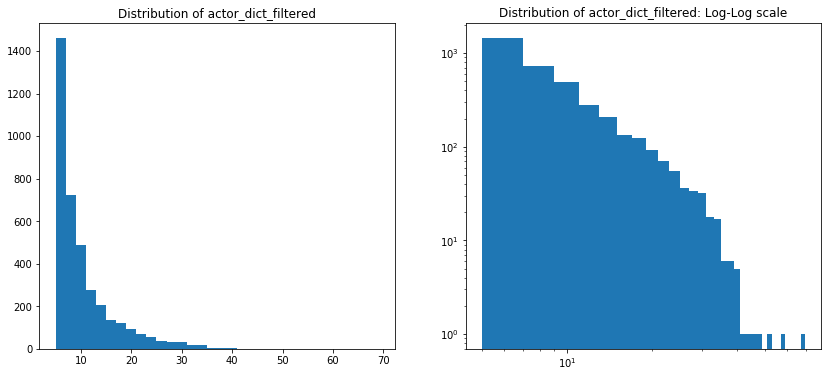

In [218]:
# ---------- Subsample actors acoording to their distribution ---------- #
def compute_distribution(actor_dict_filtered):
    '''
        Compute and plot distribution of actor_dict_filtered.
    '''
    # Count number of movies of each actor
    actor_movie_count_list = []
    for name in actor_dict_filtered.keys():
        actor_movie_count_list.append(actor_dict_filtered[name].shape[0])
    # Plot histogram of actor_dict_filtered
    bin_width = 2
    bin_num = np.floor((max(actor_movie_count_list) + 1 - min(actor_movie_count_list)) / bin_width) + 1
    bin_list = np.arange(bin_num + 1)
    bin_list = bin_list * bin_width + min(actor_movie_count_list)
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    bins_properties = plt.hist(actor_movie_count_list, bins=bin_list)
    plt.title('Distribution of actor_dict_filtered')
#     plt.savefig('./data/Histogram_of_actor_filtered.png', dpi=300)
    plt.subplot(1, 2, 2)
    bins_properties = plt.hist(actor_movie_count_list, bins=bin_list)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distribution of actor_dict_filtered: Log-Log scale')
    # Compute distribution of actor_dict_filtered
    actor_movie_count_set = set(actor_movie_count_list)
    proportion_dict = {}
    for count in actor_movie_count_set:
        bin_index = int((count - min(actor_movie_count_list)) / bin_width)
        proportion_dict[str(count)] = bins_properties[0][bin_index] / sum(bins_properties[0])
    return proportion_dict

def subsample_according_to_distribution(actor_dict_filtered, proportion_dict, subsample_amount, seed=0):
    '''
        In order to have a better visualization, we subsample actors' list according to their distribution.
    '''
    if subsample_amount > len(actor_dict_filtered.keys()):
        subsample_amount = len(actor_dict_filtered.keys())
    # Count number of movies of each actor
    actor_movie_count_list = []
    for name in actor_dict_filtered.keys():
        actor_movie_count_list.append(actor_dict_filtered[name].shape[0])
    # Subsample according to distribution
    actor_movie_count_list = np.array(actor_movie_count_list)
    choice_p_list = [proportion_dict[str(i)] for i in actor_movie_count_list]
    choice_p_list = choice_p_list / np.sum(choice_p_list)
#     print(len(choice_p_list), sum(choice_p_list))
    np.random.seed(seed)
    actor_choice_list = np.random.choice(list(actor_dict_filtered.keys()), size=subsample_amount, replace=False, p=choice_p_list)
    actor_dict_sampled = {}
    for name in actor_choice_list:
        actor_dict_sampled[name] = actor_dict_filtered[name]
    print('We have {} actors before and {} actors left after filtering.' \
      .format(len(actor_dict_filtered.keys()), len(actor_dict_sampled.keys()))) 
    return actor_dict_sampled

# Only leave 400 actors
subsample_amount = 400
seed = 1# 0, 1, 6
proportion_dict = compute_distribution(actor_dict_filtered)
actor_dict_sampled = subsample_according_to_distribution(actor_dict_filtered, proportion_dict, subsample_amount, seed)

###  Create adjacency matrix according to actors' coocurance

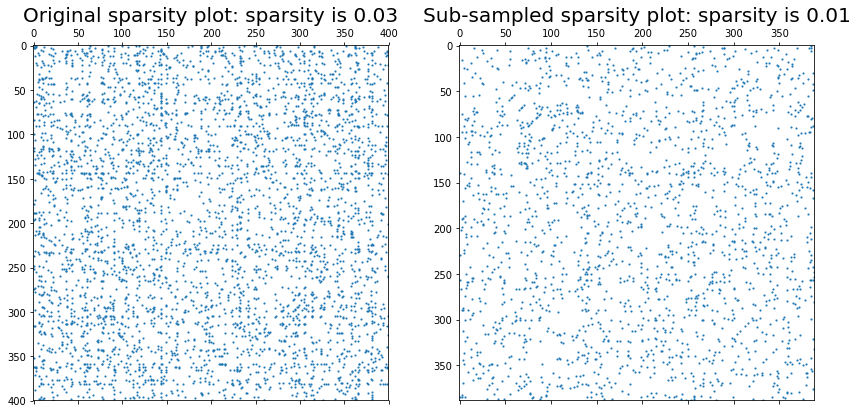

In [451]:
# ---------- Create cooccurrance matrix according to actors' coocurance ---------- #
def create_cooccurrance_matrix(actor_dict):
    '''
        Create cooccurrance matrix whose entry is the number of movies two actors appear together.
    '''
    actor_distinct_list = list(actor_dict)
    actor_num = len(actor_distinct_list)
    cooccurrence_matrix = np.zeros((actor_num, actor_num))
    co_moviemeta_matrix_dict = {}
    for index_A in range(actor_num):
        actor_A = actor_distinct_list[index_A]
        actor_A_index = actor_dict[actor_A].index
        for index_B in range(index_A + 1, actor_num):
            actor_B = actor_distinct_list[index_B]
            actor_B_index = actor_dict[actor_B].index
            # Compute common movie index
            common_index = actor_A_index.intersection(actor_B_index)
            # Compute matrix
            count = len(common_index)
            if count != 0:
                cooccurrence_matrix[index_A, index_B] = count
                cooccurrence_matrix[index_B, index_A] = count
                co_moviemeta_matrix_dict[str(index_A) + ',' + str(index_B)] = actor_dict[actor_A].loc[common_index]
                co_moviemeta_matrix_dict[str(index_B) + ',' + str(index_A)] = actor_dict[actor_A].loc[common_index]
        # Report the precedure
        if index_A % 20 == 0:
            percentage = 100 * index_A / actor_num
            print(f'{percentage:.2f}% tasks have been finished.', end = '\r')
    print(f'Cooccurrance matrix creation task has been finished.', end = '\r')
    return cooccurrence_matrix, co_moviemeta_matrix_dict

cooccurrance_matrix, _ = create_cooccurrance_matrix(actor_dict_sampled)
cooccurrance_matrix_filtered, _ = create_cooccurrance_matrix(actor_dict_filtered)
# Visualize sparsity of cooccurrence matrix
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.spy(cooccurrance_matrix_filtered[:400, :400], markersize=1)
sparsity = sparse.csr_matrix(cooccurrance_matrix_filtered).nnz / cooccurrance_matrix_filtered.shape[0]**2
plt.title('Original sparsity plot: sparsity is {:.2f}'.format(sparsity), fontsize=20)

# Visualize sparsity of cooccurrence matrix
plt.subplot(1, 2, 2)
plt.spy(cooccurrence_matrix, markersize=1)
sparsity = sparse.csr_matrix(cooccurrence_matrix).nnz / cooccurrence_matrix.shape[0]**2
plt.title('Sub-sampled sparsity plot: sparsity is {:.2f}'.format(sparsity), fontsize=20)
# plt.savefig('./data/Sparsity.png', dpi=300)
plt.show()

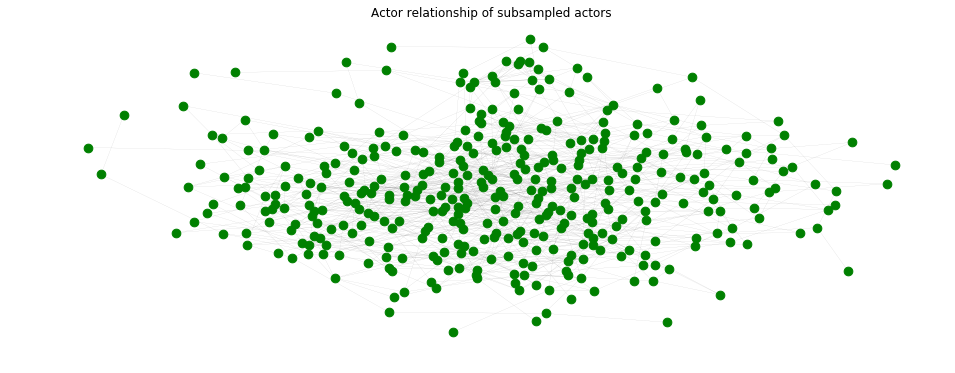

In [240]:
# ---------- Visualize network ---------- #
def visualize_network(cooccurrence_matrix, actor_dict_sampled):
    plt.figure(figsize=(16, 6))
    actor_network = nx.from_numpy_matrix(cooccurrence_matrix)
    # Map node label to actor name
    actor_distinct_list = list(actor_dict_sampled.keys()) 
    mapping = {old_label:new_label for old_label, new_label in zip(list(actor_network.nodes()), actor_distinct_list)}
    actor_network = nx.relabel_nodes(actor_network, mapping)
    # Find largest component
    comp = list(nx.connected_components(actor_network))
    largest_comp = list(max(comp, key=len))
    largest_comp = actor_network.subgraph(largest_comp)
    # Draw largest component
    pos = nx.spring_layout(largest_comp, k=0.2)
    nx.draw_networkx_edges(largest_comp, pos, width=0.1, alpha=0.4)
    nx.draw_networkx_nodes(largest_comp, pos, node_color='g', cmap=plt.cm.jet, node_shape='.')
#     print(largest_comp.nodes)
    # Show plot
    plt.axis('off')
    plt.title('Actor relationship of subsampled actors')
    plt.show()
#     print(len(largest_comp.nodes)/len(actor_network.nodes))
    return largest_comp

largest_comp_network = visualize_network(cooccurrance_matrix, actor_dict_sampled)

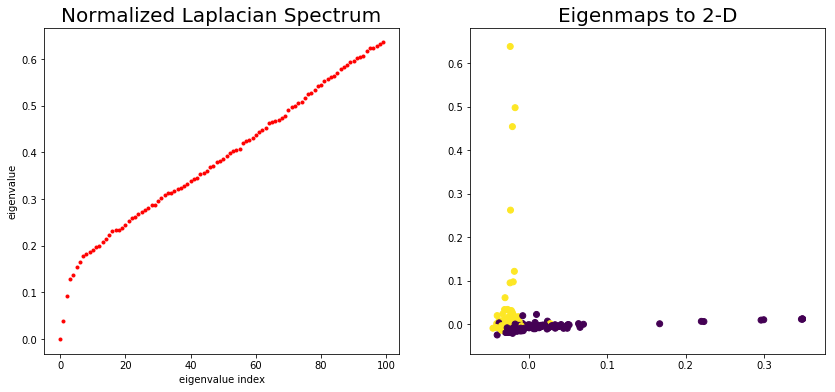

In [445]:
# ---------- Visualize Eigenmaps and Kmeans ---------- #
def Kmeans(laplacian, k, d):
    vals, vecs = sparse.linalg.eigsh(laplacian, d, which='SM')
    # Normalize data
    for i in range(vecs.shape[0]):
        vecs[i, :] = (vecs[i, :] - np.mean(vecs[i, :])) / np.std((vecs[i, :]))
    kmeans = KMeans(n_clusters = k, random_state=0).fit(np.real(vecs))
    label = kmeans.labels_
    return label
# Visualize Eigenmaps
plt.figure(figsize=(14, 6))
# Compute normalized laplacian
cooccurrence_matrix = np.array(nx.to_numpy_matrix(largest_comp_network))
degrees = np.sum(cooccurrence_matrix, axis=1)
degrees_csr = sparse.csr_matrix(np.diag(degrees))
cooccurrence_matrix_csr = sparse.csr_matrix(cooccurrence_matrix)
laplacian_combinatorial_csr = degrees_csr - cooccurrence_matrix_csr
laplacian_normalized_csr = degrees_csr.power(-0.5).dot(laplacian_combinatorial_csr).dot(degrees_csr.power(-0.5))
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian_normalized_csr, k=100, which='SM')
# Plot eigen values
plt.subplot(1, 2, 1)
plt.plot(eigenvalues, 'r.')
plt.xlabel('eigenvalue index')
plt.ylabel('eigenvalue')
plt.title('Normalized Laplacian Spectrum', fontsize=20)
# Kmeans and eigenmaps
plt.subplot(1, 2, 2)
feature_dimension = 6
clusters_num = 2
labels = Kmeans(laplacian_normalized_csr, clusters_num, feature_dimension)
plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c = labels)
plt.title('Eigenmaps to 2-D', fontsize=20)
# plt.savefig('./data/Eigenmaps.png', dpi=300)
plt.show()

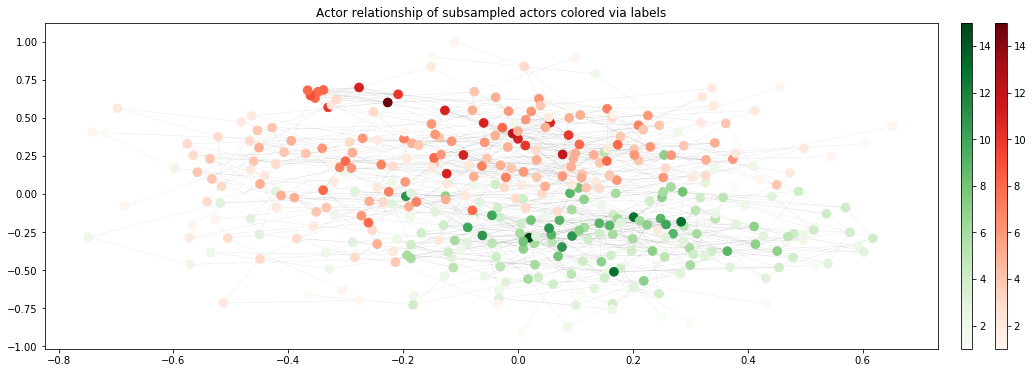

In [466]:
# ---------- Visualize actor social network ---------- #
from networkx.drawing.nx_agraph import graphviz_layout
pos = nx.spring_layout(largest_comp_network, k=0.2, random_state=3) 
subgraph_label1 = largest_comp_network.subgraph(np.array(largest_comp_network.nodes)[labels==1])
subgraph_label0 = largest_comp_network.subgraph(np.array(largest_comp_network.nodes)[labels==0])
# Plot actor social network and color nodes according to degrees of node and label
fig = plt.figure(figsize=(16, 6))
nx.draw_networkx_edges(subgraph_label1, pos, width=0.1, alpha=0.4)
nodes_1 = nx.draw_networkx_nodes(subgraph_label1, 
                               pos, 
                               node_color=np.array(list(dict(subgraph_label1.degree).values())), 
                               cmap='Greens',
                               node_shape='.')
nx.draw_networkx_edges(subgraph_label0, pos, width=0.1, alpha=0.4)
nodes_0 = nx.draw_networkx_nodes(subgraph_label0, 
                               pos, 
                               node_color=np.array(list(dict(subgraph_label0.degree).values())), 
                               cmap='Reds',
                               node_shape='.')
plt.title('Actor relationship of subsampled actors colored via labels')
bbox_ax = fig.axes[0].get_position()
# Add colorbars
cbar_im1a_ax = fig.add_axes([0.92, bbox_ax.y0, 0.01, bbox_ax.y1-bbox_ax.y0])
cbar_im1a = plt.colorbar(nodes_1, cax=cbar_im1a_ax)
cbar_im2a_ax = fig.add_axes([0.95, bbox_ax.y0, 0.01, bbox_ax.y1-bbox_ax.y0])
cbar_im1a = plt.colorbar(nodes_0, cax=cbar_im2a_ax)
# fig.savefig('./data/Networks.png', dpi=300)

In [454]:
# ---------- Obtain 5 most 'sociable' actors in each ---------- #
subgraph_label0_df = pd.DataFrame.from_dict(dict(subgraph_label0.degree), orient='index') 
subgraph_label0_df = subgraph_label0_df.reset_index()
subgraph_label0_df.columns = ['Name', 'Degree']
print("The 5 most 'sociable' actors in cluster 0:")
subgraph_label0_df.sort_values('Degree', ascending=False).head()

The 5 most 'sociable' actors in cluster 0:


,Name,Degree
128,Julian Glover,15
111,Jason Ritter,12
44,Spencer Wilding,12
87,David Kelly,11
15,Elwin 'Chopper' David,11


In [455]:
subgraph_label1_df = pd.DataFrame.from_dict(dict(subgraph_label1.degree), orient='index') 
subgraph_label1_df = subgraph_label1_df.reset_index()
subgraph_label1_df.columns = ['Name', 'Degree']
print("The 5 most 'sociable' actors in cluster 1:")
subgraph_label1_df.sort_values('Degree', ascending=False).head()

The 5 most 'sociable' actors in cluster 1:


,Name,Degree
108,Vera Farmiga,16
78,Kevin Corrigan,14
41,Adam LeFevre,13
144,Marcia Gay Harden,13
190,Carlos Alazraqui,13


# Word2Vec

In [265]:
try:
    model = gensim.models.Word2Vec.load('./data/64_features_model')
    print('The vocabulary count in the model is {}.'.format(len(model.wv.vocab)))
except:
    movie_data_scraped_path = '/movie_data.csv'
    movie_data_scraped_df = pd.read_csv(File_path + movie_data_scraped_path, dtype=str, engine='python')
    movie_keywords_scraped = movie_data_scraped_df['keywords'].map(lambda x: re.sub('[0-9]+\-[0-9]+\-[0-9]+','nan', x))
    movie_keywords_scraped = movie_keywords_scraped[movie_keywords_scraped!='nan']
    movie_keywords_scraped = movie_keywords_scraped.\
                                map(lambda x: eval(x) if (type(eval(x))!=float and type(eval(x))!=type(None) ) else [])
    movie_keywords_scraped = movie_keywords_scraped.map(lambda x: [item['name'] for item in x])
    model = Word2Vec(movie_keywords_scraped, min_count=1, size=64)
    model.save('./data/64_features_model')

In [277]:
# Use an example to reflect the goodness of the model
model.similar_by_word('space')

[('space travel', 0.999713659286499),
 ('alien invasion', 0.9996951222419739),
 ('astronaut', 0.999618411064148),
 ('spacecraft', 0.9995511174201965),
 ('spoof', 0.9995113015174866),
 ('apocalypse', 0.9995033740997314),
 ('alien abduction', 0.9993913173675537),
 ('robot', 0.9993647336959839),
 ('giant monster', 0.9993584156036377),
 ('alien', 0.9992812275886536)]